# US Election API: Analyzing voting patterns

This notebook allows you to analyze the 2020 US presidential election by state graphically. It focuses mostly on the absolute/relative shares of votes per candidate. You can easily play around with it simply by changing the name of the state in the diverse function calls. At the end, we will also take a look at the role of absentee ballots.

In [1]:
# Import the necessary helper classes
from methods import votes_methods as vm
from plotting import plot_vote_graphs as vg

First, we scrape all the relevant information from the API:

In [2]:
# Pull the information from the API
api_results = vm.get_api_results()

# Prepare the results to be read into a data frame
df_input = vm.format_input_for_df(api_results)

# Create data frame
votes_df = vm.format_df(df_input)

# Create CSV file
votes_df.to_csv('nyt_ts.csv', encoding='utf-8')

Let's check what the data looks like:

In [3]:
votes_df.head()

,votes,eevp,timestamp,state,vote_share_rep,vote_share_dem,vote_share_trd
0,0,0,2020-11-04 10:01:44+00:00,alaska,0.000,0.000,0.000
1,113744,31,2020-11-04 07:47:41+00:00,alaska,0.605,0.352,0.043
2,132475,36,2020-11-04 08:57:55+00:00,alaska,0.614,0.347,0.039
3,172031,56,2020-11-04 18:34:58+00:00,alaska,0.629,0.330,0.041
4,190970,61,2020-11-09 19:09:13+00:00,alaska,0.622,0.336,0.042


`votes` here refers to the total number of votes already counted, not the number of votes per batch/timestamp. We further see the state and respective shares of the Republican, Democrat and Third Party votes. `eevp` is an estimator of the percentage of all votes that has already been counted.

## Global share of votes

We want to look at the results per state and also get the size of each batch, which is achieved by the `get_state_df_total()` function. To limit the number of columns, we will now also melt the frame in such a way as to have an additional `party` column (instead of one column with the vote shares per party - this will be even more practical later on.)

In [4]:
# Example for Alaska
alaska = vm.get_state_df_total('alaska', votes_df)
# Uncomment line below if you eould like to save a csv copy of the dataframe
# alaska.to_csv('state_results.csv', encoding='utf-8')
alaska.head(10)

,votes,eevp,timestamp,state,batch_size,d_r_ratio,party,vote_share
0,113744.0,31.0,2020-11-04 07:47:41+00:00,alaska,113744.0,0.582,rep,0.605
1,132475.0,36.0,2020-11-04 08:57:55+00:00,alaska,18731.0,0.565,rep,0.614
2,172031.0,56.0,2020-11-04 18:34:58+00:00,alaska,39556.0,0.525,rep,0.629
3,190970.0,61.0,2020-11-09 19:09:13+00:00,alaska,18939.0,0.540,rep,0.622
4,240234.0,75.0,2020-11-11 02:46:15+00:00,alaska,49264.0,0.657,rep,0.580
5,260983.0,75.0,2020-11-11 13:18:28+00:00,alaska,20749.0,0.687,rep,0.569
6,286788.0,78.0,2020-11-12 16:41:43+00:00,alaska,25805.0,0.721,rep,0.559
7,312033.0,99.0,2020-11-13 02:25:15+00:00,alaska,25245.0,0.778,rep,0.541
8,325194.0,99.0,2020-11-13 13:55:46+00:00,alaska,13161.0,0.797,rep,0.533
9,334789.0,99.0,2020-11-14 02:43:02+00:00,alaska,9595.0,0.798,rep,0.535


How are the votes distributed? We just have to specify the state in the plotting function and will see 

- the shares per party over time
- the ratio of Dem vs Rep votes

The parameters `minus_days` and `minus_hours` (both default 0) allows to limit the length of the x-axis by cutting off more recent days: In many cases, there are still new batches coming in even many days after the election. I recommend setting it to default first and the zooming in by increasing it.

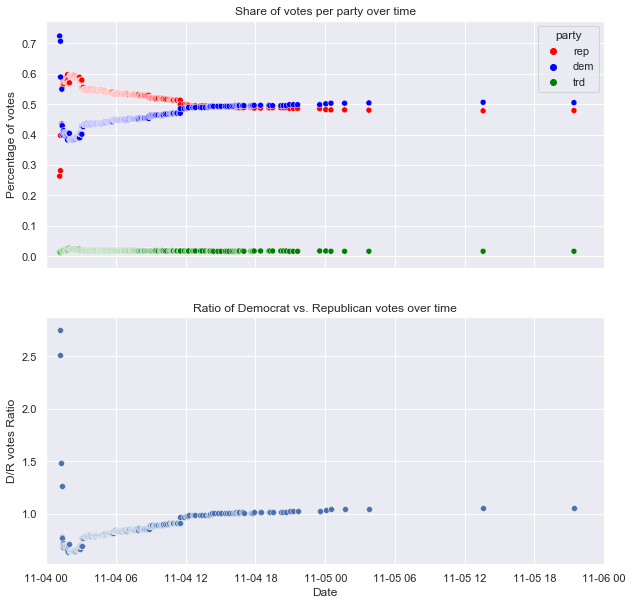

In [5]:
vg.plot_percentage('michigan', votes_df, minus_days = 7)

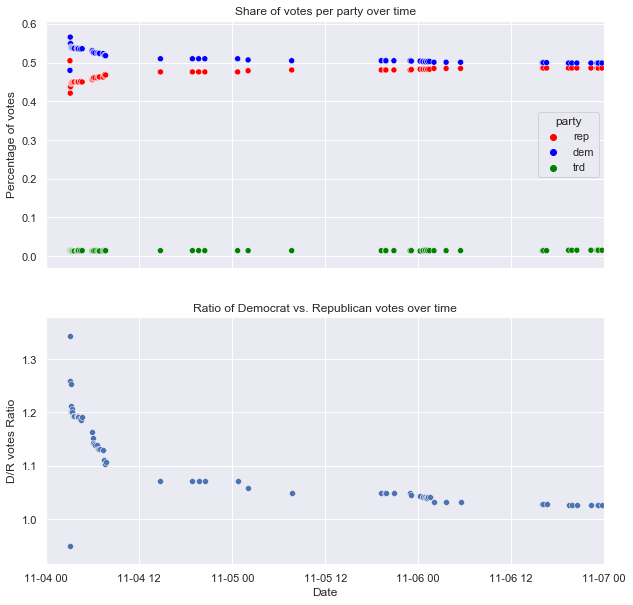

In [6]:
vg.plot_percentage('arizona', votes_df, minus_days = 7)

## Share of votes by batch

With the information at hand, it is actually possible to calculate the percentage of votes per party *for each batch*, and not just globally. Here's an easy example how this works:

| Total Votes   | Share of total votes           | Share of batch votes  |
| ------------- |:-------------:                 | -----:|
| n1            | 50%                               | 50% | 
| n2            | 40%                              |   (0.4 * n2 - 0.5 * n1) / (n2 - n1) |

where `n1` and `n2` are the total votes from two succesive timestamps (so n2 > n1). `get_state_df_batch` will perform these calculations for us.

In [7]:
#Example: Wisconsin
wisc_batch = vm.get_state_df_batch('wisconsin', votes_df)
#wisc_batch.to_csv('batch_results.csv', encoding='utf-8')
wisc_batch.head()

,votes,eevp,timestamp,state,batch_size,d_r_ratio,party,vote_share,num_votes,delta_votes,batch_share
0,1095.0,0.0,2020-11-04 02:14:29+00:00,wisconsin,1095.0,2.832,rep,0.256,280.0,280.0,0.256
1,9001.0,0.0,2020-11-04 02:18:58+00:00,wisconsin,7906.0,0.585,rep,0.619,5572.0,5292.0,0.669
2,43641.0,1.0,2020-11-04 02:23:05+00:00,wisconsin,34640.0,1.738,rep,0.359,15667.0,10095.0,0.291
3,109676.0,3.0,2020-11-04 02:24:58+00:00,wisconsin,66035.0,0.812,rep,0.543,59554.0,43887.0,0.665
4,116441.0,3.0,2020-11-04 02:27:50+00:00,wisconsin,6765.0,0.787,rep,0.550,64043.0,4489.0,0.664


Before we turn to the batches, let's first see how the total votes per party evolve over time. The `minus_days` works just the same way here. Feel free to insert any state you're interested in.

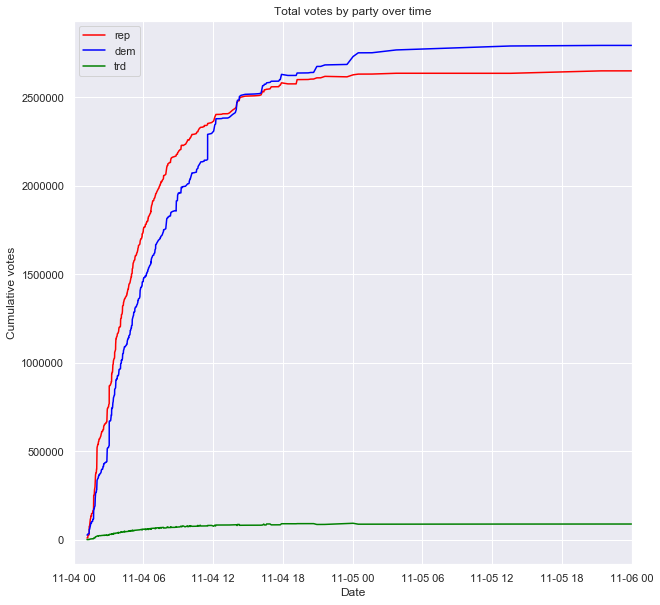

In [8]:
vg.plot_total('michigan', votes_df, minus_days = 7)

We can see that there are some problematic things going on. How can the total number of votes be lower at some later point in time than before? We suspect these are reporting mistakes, but it is not obvious how to deal with them. The solution on which I settled here was simply to restrict the y-axis to values that make sense, simply because I do not know what's behind those mistakes in the data.

With this provisio, we can check what the results by batch look like - first graph gives the percentages, the second one the total votes per candidate per batch.

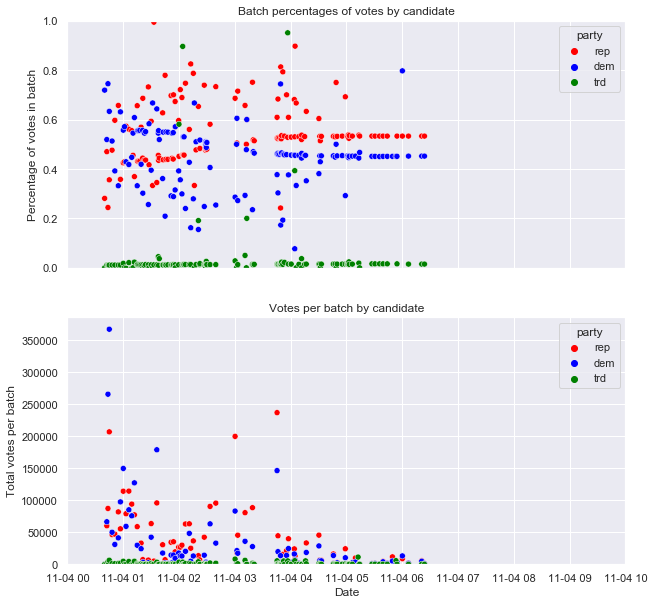

In [9]:
vg.plot_batch_percentage('ohio', votes_df, minus_days = 3, minus_hours = 38)

## Absentee ballots

The last thing I want to show here is the vote shares for the two major parties, and compare it with the share of votes they received from absentee ballots, as this is allegedly where all the fraud is coming from. You can pass whichever states you are interested in in the `states` list below to generate the bar plot. 

If you remove the `states` argument empty, the results for all states will be displayed.

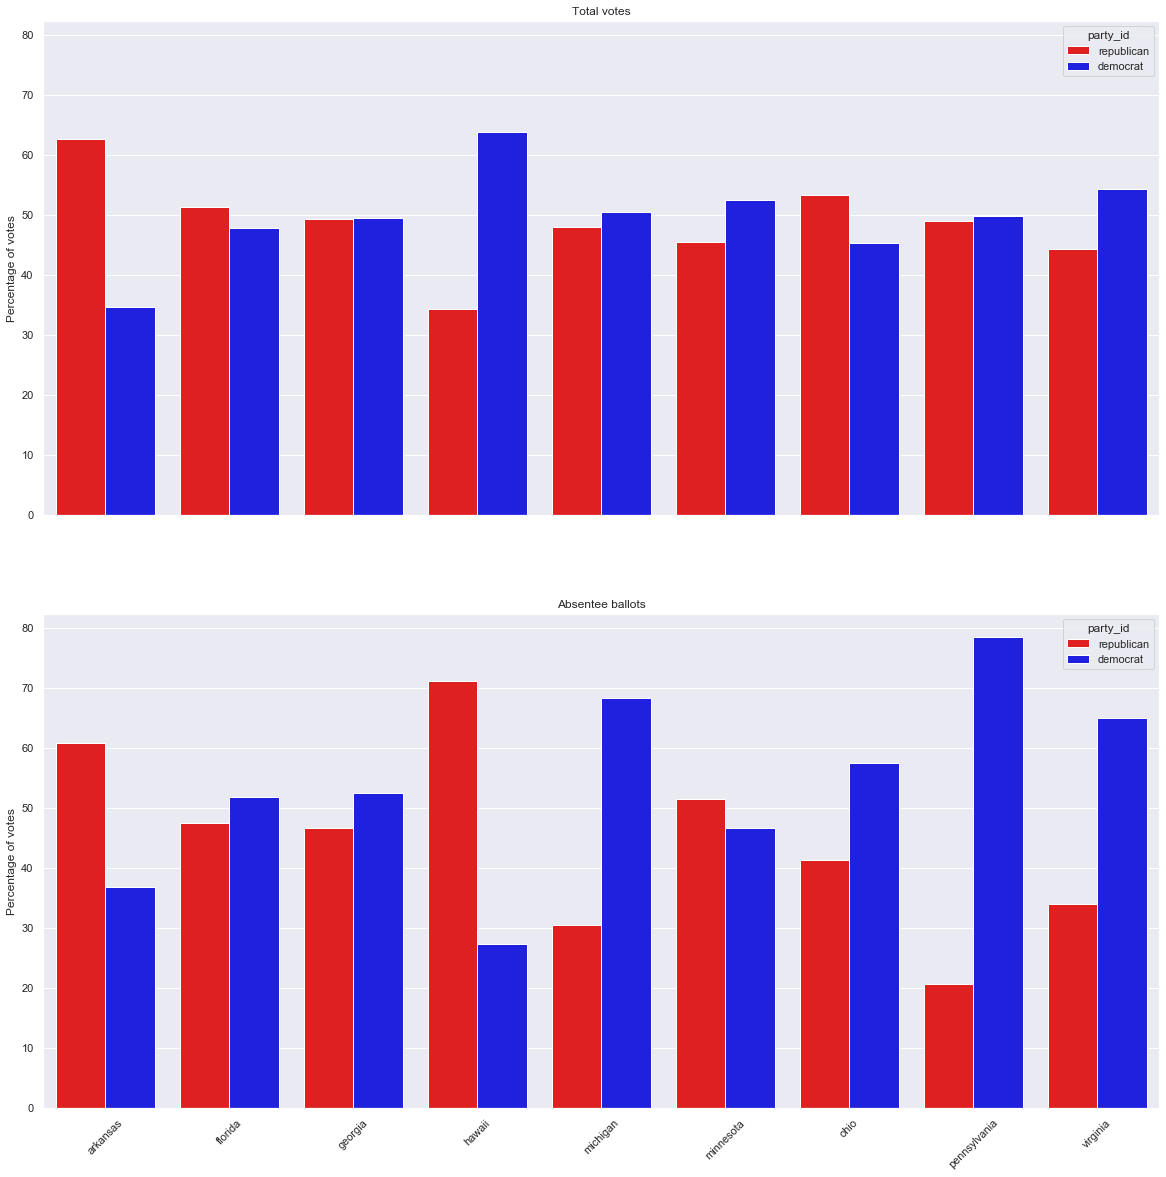

In [10]:
states = ['michigan', 'virginia', 'florida', 'pennsylvania', 'minnesota', 'georgia', 'arkansas', 'ohio', 'hawaii']
vg.plot_absentee_percentage(api_results, list_of_states = states)

You can no doubt plot a great many other things using this API, and I invite you to play aroudn with it and write your own methods, but this should at least be a good place to get started.